In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import xarray as xr
from xgcm import Grid
import numpy as np

In [45]:
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/1yr/'
gridname = 'native'
prefix = '19000101.ocean_'
suffixs = ['1900','heat','salt','snap']
ds = xr.Dataset()
for suffix in suffixs[0:3]:
    print(suffix)
    filename = prefix+gridname+'_'+suffix+'*.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
# Load snapshots into separate dataset to avoid conflicts
print(suffixs[-1])
filename = prefix+gridname+'_'+suffixs[-1]+'*.nc'
snap = xr.open_mfdataset(rootdir+filename)
gridname = '19000101.ocean_static.nc'
grid = xr.open_dataset(rootdir+gridname).squeeze()
# Vertical pseudo-grid
grid['zl'] = -ds['zl']
grid['zi'] = -ds['zi']
grid['dzt'] = -grid['zl'].copy(data=grid['zi'].diff('zi'))
grid = grid.squeeze() # Get rid of any remnant time variables

1900
heat
salt
snap


In [46]:
# Build xgcm grid object
# (see https://mom6-analysiscookbook.readthedocs.io/en/latest/01c_getting_started.html#building-a-xgcm-grid-object)

# Fill in nans with zeros
grid['dxt'] = grid['dxt'].fillna(0.)
grid['dyt'] = grid['dyt'].fillna(0.)
grid['dzt'] = grid['dzt'].fillna(0.) # Time-varying cell thickness
grid['areacello'] = grid['areacello'].fillna(0.)
grid['volcello'] = (grid['areacello']*ds['thkcello']).fillna(0.)

metrics = {
    ('X',): ['dxt','dxCu','dxCv'], # X distances
    ('Y',): ['dyt','dyCu','dyCv'], # Y distances
    ('Z',): ['dzt'], # Z distances
    ('X', 'Y'): ['areacello'], # Areas
    ('X', 'Y', 'Z'): ['volcello'], # Volumes
}

coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'},
        'Z': {'center': 'zl', 'outer': 'zi'} }

xgrid = Grid(grid, coords=coords, periodic=False)

In [89]:
var = 'opottemptend'
new_levels = np.arange(4,12,0.01)
var_on_new = xgrid.transform(ds[var],'Z',target=new_levels,target_data=ds['temp'],method='conservative')

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xgcm-0.4.0+18.ge0eae1e-py3.8.egg/xgcm/grid.py:934: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.


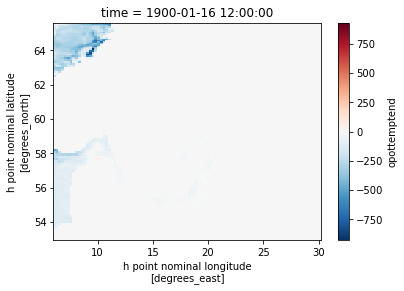

In [90]:
var_on_new.isel(time=0).sum('temp').plot()

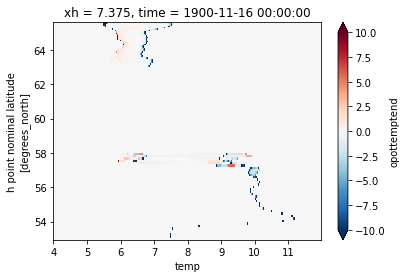

In [91]:
var_on_new.isel(xh=5,time=10).plot(vmax=10)

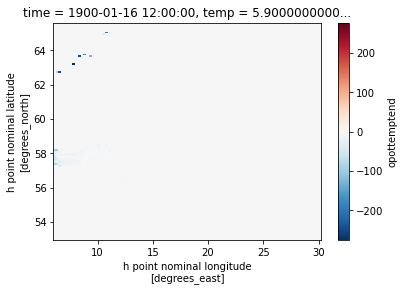

In [70]:
var_on_z.sel(temp=6,method='nearest').isel(time=0).plot()

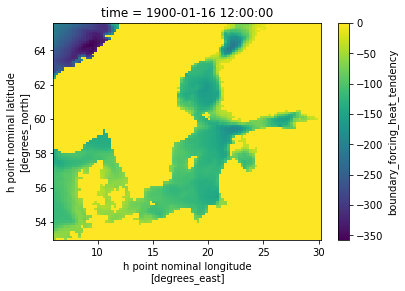

In [38]:
ds[var].isel(time=0).sum('zl').plot()

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


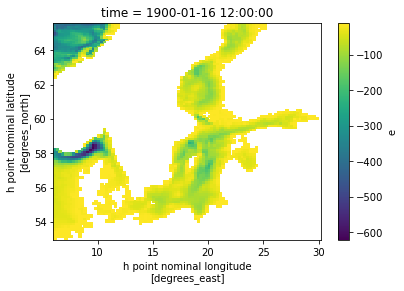

In [20]:
ds['e'].isel(time=0).min('zi').plot()

In [116]:
select = {'xh':5,'yh':56}
dsnow = ds.sel(select,method='nearest').isel(time=0,nv=0).squeeze()

In [44]:
grid['dzt']

<xarray.DataArray 'dzt' (zl: 75)>
array([-2.00000e+00, -2.00000e+00, -2.00000e+00, -2.00000e+00, -2.00000e+00,
       -2.00000e+00, -2.00000e+00, -2.01000e+00, -2.01000e+00, -2.02000e+00,
       -2.03000e+00, -2.05000e+00, -2.08000e+00, -2.11000e+00, -2.15000e+00,
       -2.21000e+00, -2.28000e+00, -2.37000e+00, -2.48000e+00, -2.61000e+00,
       -2.77000e+00, -2.95000e+00, -3.17000e+00, -3.43000e+00, -3.74000e+00,
       -4.09000e+00, -4.49000e+00, -4.95000e+00, -5.48000e+00, -6.07000e+00,
       -6.74000e+00, -7.50000e+00, -8.34000e+00, -9.28000e+00, -1.03300e+01,
       -1.14900e+01, -1.27700e+01, -1.41900e+01, -1.57400e+01, -1.74500e+01,
       -1.93100e+01, -2.13500e+01, -2.35600e+01, -2.59700e+01, -2.85800e+01,
       -3.14100e+01, -3.44700e+01, -3.77700e+01, -4.13200e+01, -4.51400e+01,
       -4.92500e+01, -5.36500e+01, -5.83700e+01, -6.34200e+01, -6.88100e+01,
       -7.45600e+01, -8.06800e+01, -8.72100e+01, -9.41400e+01, -1.01510e+02,
       -1.09330e+02, -1.17620e+02, -1.26400e+02, -1.35680e+02, -1.45500e+02,
       -1.55870e+02, -1.66810e+02, -1.78350e+02, -1.90510e+02, -2.03310e+02,
       -2.16780e+02, -2.30930e+02, -2.45800e+02, -2.61420e+02, -2.77783e+03])
Coordinates:
    time     object 1900-01-01 00:00:00
  * zl       (zl) float64 -1.0 -3.0 -5.0 ... -3.338e+03 -3.591e+03 -5.111e+03

In [64]:
# Get interface height at cell centers
ds['e_l'] = ds['thkcello'].copy(data=0.5*(ds['e'][:,1:,:,:].data+ds['e'][:,:1,:,:].data))
ds['e_l'] = ds['e_l'].assign_attrs({'long_name':'Height of grid cell center relative to mean sea level'})
ds['e_l']

<xarray.DataArray 'e_l' (time: 12, zl: 75, yh: 105, xh: 97)>
dask.array<mul, shape=(12, 75, 105, 97), dtype=float32, chunksize=(1, 75, 105, 97), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 6.125 6.375 6.625 6.875 ... 29.38 29.62 29.88 30.12
  * yh       (yh) float64 53.01 53.16 53.31 53.46 ... 65.31 65.39 65.48 65.56
  * zl       (zl) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
  * time     (time) object 1900-01-16 12:00:00 ... 1900-12-16 12:00:00
Attributes:
    long_name:      Height of grid cell center relative to mean sea level
    units:          m
    cell_methods:   area:mean zl:sum yh:mean xh:mean time: mean
    cell_measures:  area: area_t
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  cell_thickness